In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import imantics
from skimage.transform import resize
import random
from skimage import util
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from keras.applications.vgg16 import preprocess_input 
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [2]:
base_dir = ''
annote_dir = 'archive/annotations/instances_default.json'
images_dir = 'archive/images' 

In [3]:
images_listdir = os.listdir(images_dir)

In [4]:
image_size = 512
input_image_size = (1920 , 1080)

In [5]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    return img

In [6]:
def print_images(number,rows,cols,images_to_sample,mask=None):
  random_numbers = [random.randint(0,len(images_to_sample)-1) for _ in range(number)]
  fig, ax = plt.subplots(rows, cols, figsize = (12,8))
  if mask is not None and len(mask) == len(images_to_sample):
    for i, ax in enumerate(ax.flat):
        if i < len(random_numbers):
            ax.imshow(images_to_sample[i])
            ax.imshow(mask[i], alpha=0.5)
            ax.axis('off')
  else:
      for i, ax in enumerate(ax.flat):
        if i < len(random_numbers):
            ax.imshow(images_to_sample[i])
            ax.axis('off')

In [7]:
def print_images_with_text(number, rows, cols, images_to_sample, mask=None, texts=None):
    random_numbers = [random.randint(0, len(images_to_sample)-1) for _ in range(number)]
    fig, ax = plt.subplots(rows, cols, figsize=(12, 8))
    
    for i, ax in enumerate(ax.flat):
        if i < len(random_numbers):
            image = images_to_sample[random_numbers[i]]
            ax.imshow(image)
            ax.axis('off')
            
            if mask is not None and len(mask) == len(images_to_sample):
                mask_image = mask[random_numbers[i]]
                if mask_image.shape[:2] == image.shape[:2]:
                    ax.imshow(mask_image, alpha=0.5)
            
            if texts is not None and len(texts) == len(images_to_sample):
                ax.set_title(texts[random_numbers[i]], fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [8]:
annote = json.load(open(annote_dir))

In [9]:
id_to_images = {image['id']:image['file_name'] for image in annote['images']}

In [10]:
images = np.zeros((len(images_listdir), image_size, image_size, 3), dtype=np.uint8)

In [11]:
for image_id, image_filename in id_to_images.items():
    cur_image = read_image(f"{images_dir}/{image_filename}")
    images[image_id - 1] = cur_image

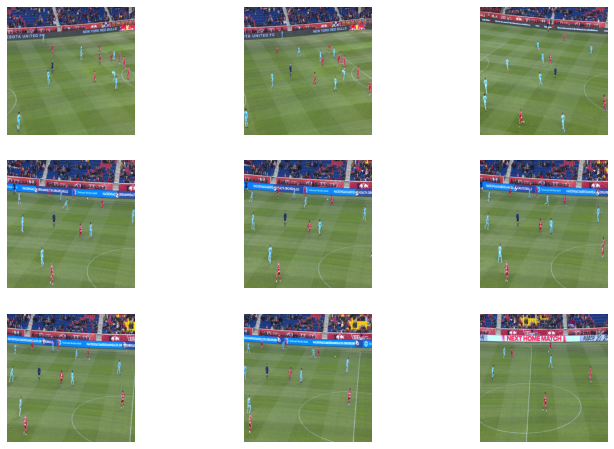

In [12]:
print_images(9,3,3,images,None)

In [13]:
masks = np.zeros((len(images_listdir), image_size, image_size, 1), dtype=bool)
for annotation in annote["annotations"]:
    image_id = annotation["image_id"]
    segmentation = annotation["segmentation"]

    cur_mask = imantics.Polygons(segmentation).mask(*input_image_size).array
    cur_mask = np.expand_dims(resize(cur_mask, (image_size, image_size), mode='constant', preserve_range=True), 2)

    mask_index = image_id - 1
    masks[mask_index] = masks[mask_index] | cur_mask

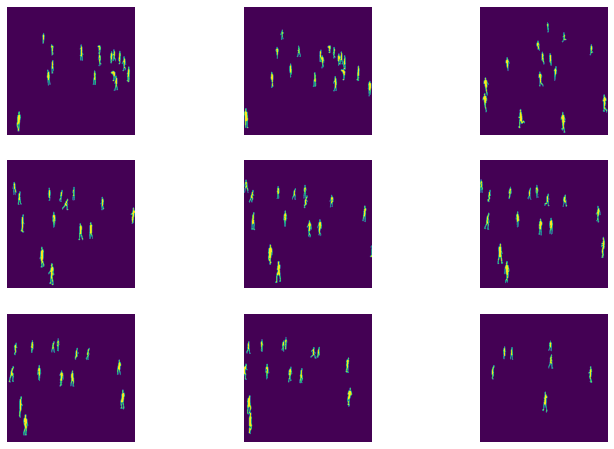

In [14]:
print_images(9,3,3,masks)

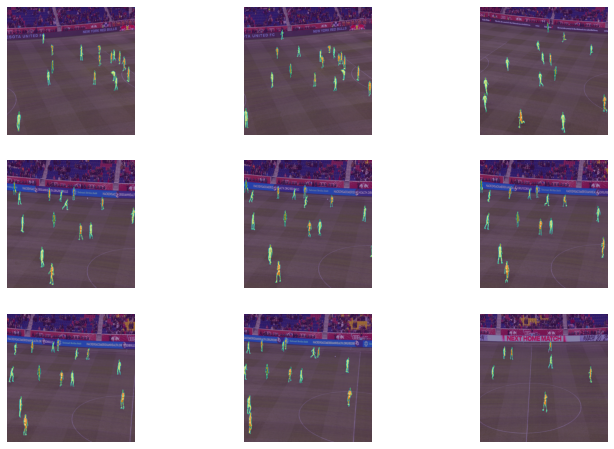

In [15]:
print_images(9,3,3,images,masks)

In [17]:
def apply_mask(image,overlay):
    overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2BGR)

    masked_image = cv2.bitwise_and(image, overlay, overlay)
    
    return masked_image

In [18]:
def extract_features(img):
  hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
# Extract Hue and Saturation components
  hue = hsv_image[:,:,0].flatten()
  saturation = hsv_image[:,:,1].flatten()

  # Combine the color components into a single array
  color_data = np.column_stack((hue, saturation))

  # Reshape the color_data array to a single row with multiple columns
  color_data_1d = color_data.reshape((1, -1))
  # Convert pixel values to float
  data = np.float32(color_data_1d)
  return data

In [19]:
def Build_teams_classifier(images,masks , test = None):

  players = []
  data = []

  count_images = 0
  for image in images:
    img = image.copy()
    mask = masks[count_images]
    mask_result = []
    result = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = mask[:,:,0]
    count = 0
  # Perform connected component analysis on the binary image
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh.astype(np.uint8))

    count = 0
    # Loop through the connected components and extract the white regions
    for i in range(1, len(stats)):
      # Get the bounding box coordinates of the component
      x, y, w, h, area = stats[i]
      segment = np.full_like(mask, 0)
      segment[y:y+h, x:x+w,:] = 255
      mask_uint8 = mask.astype(np.uint8)
      segment_uint8 = segment.astype(np.uint8)
      overlay = (cv2.bitwise_and(mask_uint8,segment_uint8)*255).astype(np.uint8)
      
      img1 = apply_mask(img[y:y+h, x:x+w,:],overlay[y:y+h, x:x+w])

      
      img1 = cv2.resize(img1, (image_size, image_size))
      players.append(img1)
      feat = extract_features(img1)
      data.append(feat)

      count += 1
    count_images += 1

  features = np.vstack(data)

  # cluster feature vectors
  kmeans = KMeans(n_clusters=2)
  kmeans.fit(features)
  if test != None:
    labels = kmeans.predict(extract_features(players[test]))
    print(labels)
    plt.imshow(players[test])
    plt.show()
  return kmeans,players


In [166]:
def classify_status(w,h,img):
  result = []
  threshold = 10
  black_count =0
  for i in range(w):
    for j in range(h):
      if img[j,i] == 0:
        black_count +=1

  
  black_count = np.array(black_count)

  ratio_black = (black_count/(w*h))
  ratio = h/w
  if h <= threshold and w <= threshold:
    text = "N/A"
  elif ratio >= 2:
    text = f"standing"
  elif ratio<0.8:
    text = f"leaning"
  elif ratio_black>0.7:
    text = f"standing"
  else:
    
    text = f"crouching"
  result = text
  return result

In [131]:
def classify_players(image,mask,model):
  mask_result = []
  img = image.copy()
  result = image.astype(np.uint8)
  thresh = mask[:,:,0]
  players = []
  player_description = []
  # Define the data for the table
  player_description = [
      ['Number', 'Status', 'Team'],

  ]
  # Perform connected component analysis on the binary image
  _, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh.astype(np.uint8))

  count = 0
  # Loop through the connected components and extract the white regions
  for i in range(1, len(stats)):
    # Get the bounding box coordinates of the component
    x, y, w, h, area = stats[i]
    segment = np.full_like(mask, 0)
    segment[y:y+h, x:x+w,:] = 255
    mask_uint8 = mask.astype(np.uint8)
    segment_uint8 = segment.astype(np.uint8)
    overlay = (cv2.bitwise_and(mask_uint8,segment_uint8)*255).astype(np.uint8)

    img1 = apply_mask(img[y:y+h, x:x+w,:],overlay[y:y+h, x:x+w])

    img1 = cv2.resize(img1, (image_size, image_size))
    team = extract_features(img1)
    
    player_description.append(["player"+str(count),classify_status(w,h,overlay[y:y+h, x:x+w]),str(model.predict(team))])


    players.append(img1)


    cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
    mask_result.append(overlay)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 1
    text_size, _ = cv2.getTextSize("player"+str(count), font, font_scale, thickness)
    text_x = x + (w - text_size[0]) // 2
    text_y = y - text_size[1] - 5
    cv2.putText(result, "player "+str(count), (text_x, text_y), font, font_scale, (0, 0, 255), thickness)
    count +=1
  return player_description,result

  



In [127]:
def print_data(data,img):
    plt.imshow(img)
    plt.show()
        # Calculate the maximum width for each column
    column_widths = [max(len(str(item)) for item in column) for column in zip(*data)]

    # Print the table
    for row in data:
        for i, item in enumerate(row):
            print(f'{item:{column_widths[i]}}', end='  ')
        print()

In [26]:
model,players = Build_teams_classifier(images[:50],masks[:50])

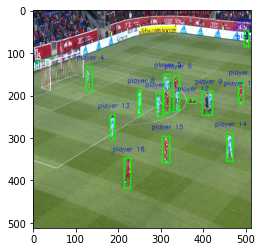

Number    Status    Team  
player0   standing  [0]   
player1   N/A       [1]   
player2   N/A       [1]   
player3   N/A       [0]   
player4   standing  [0]   
player5   standing  [0]   
player6   standing  [0]   
player7   standing  [1]   
player8   standing  [0]   
player9   standing  [0]   
player10  N/A       [0]   
player11  standing  [0]   
player12  leaning   [1]   
player13  standing  [1]   
player14  standing  [0]   
player15  standing  [0]   
player16  standing  [1]   


In [193]:
image_num = 145
player_description,result = classify_players(images[image_num],masks[image_num],model)

print_data(player_description,result)

In [27]:
texts = []
for player in players:
    feat = extract_features(player)
    texts.append(model.predict(feat))


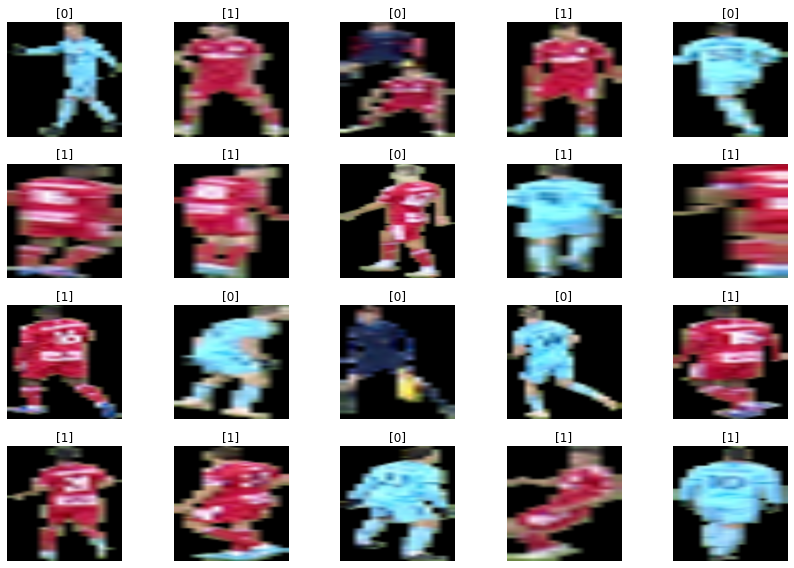

In [31]:
print_images_with_text(20,4,5,players,texts=texts)